All Imports

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
import tensorflow.keras.models as models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional, Reshape, Dropout
import matplotlib.pyplot as plt
import mlflow

Load both CSV files into pandas dataframes

In [4]:
df1 = pd.read_csv('aapl_2016_2020.csv')
df2 = pd.read_csv('aapl_2021_2023.csv')

/tmp/ipykernel_11638/3057472841.py:1: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('aapl_2016_2020.csv')
/tmp/ipykernel_11638/3057472841.py:2: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('aapl_2021_2023.csv')


Concatenate the dataframes along rows (assuming they have the same columns)

In [5]:
raw_df = pd.concat([df1, df2], ignore_index=True)

Save the merged dataframe to a new CSV file

In [6]:
raw_df.to_csv('merged.csv', index=False)

In [2]:
raw_df = pd.read_csv('merged.csv')

/tmp/ipykernel_28995/596435398.py:1: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('merged.csv')


Get rid of [ ] in the column name

In [3]:
columns = raw_df.columns
columns = [s.replace('[', '') for s in columns]
columns = [s.replace(']', '') for s in columns]
columns = [s.replace(' ', '') for s in columns]

raw_df.columns = columns

Some columns will not be handled well when converting raw numeric strings to Python's integer and float datatypes. 

Therefore, we will treat these features separately and join them again later.

In [4]:
date_columns = ['QUOTE_READTIME','QUOTE_DATE','EXPIRE_DATE','QUOTE_TIME_HOURS', 'C_SIZE', 'P_SIZE']
numeric_cols = raw_df.columns.to_list()
numeric_cols.remove('QUOTE_READTIME')
numeric_cols.remove('QUOTE_DATE')
numeric_cols.remove('EXPIRE_DATE')
numeric_cols.remove('QUOTE_TIME_HOURS')
numeric_cols.remove('C_SIZE')
numeric_cols.remove('P_SIZE')

numeric_cols

['QUOTE_UNIXTIME',
 'UNDERLYING_LAST',
 'EXPIRE_UNIX',
 'DTE',
 'C_DELTA',
 'C_GAMMA',
 'C_VEGA',
 'C_THETA',
 'C_RHO',
 'C_IV',
 'C_VOLUME',
 'C_LAST',
 'C_BID',
 'C_ASK',
 'STRIKE',
 'P_BID',
 'P_ASK',
 'P_LAST',
 'P_DELTA',
 'P_GAMMA',
 'P_VEGA',
 'P_THETA',
 'P_RHO',
 'P_IV',
 'P_VOLUME',
 'STRIKE_DISTANCE',
 'STRIKE_DISTANCE_PCT']

In [5]:
numeric_df = raw_df.drop(columns=date_columns)

for i in numeric_cols:
    numeric_df[i] = pd.to_numeric(numeric_df[i], errors='coerce')

Now we drop all rows that contains an element that is NaN

In [6]:
numeric_df = numeric_df.dropna()

Choosing our Features X and Target Y

In [7]:
X = numeric_df.drop(columns=['P_LAST', 'C_LAST'])
y = numeric_df[['P_LAST', 'C_LAST']]

Scale transform the data

In [8]:
scaler = MinMaxScaler(feature_range=(0.1, 1))
X, y = scaler.fit_transform(X), scaler.fit_transform(y)

Convert them into matrices

In [9]:
X, y = np.array(X), np.array(y)

Check Dimensions of the features and targets

In [14]:
print(X.shape, y.shape)

(872082, 25) (872082, 2)


Split data into train and test (80%:20%)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Start our MLflow run

In [13]:
mlflow.set_experiment("options_GRU_prediction")

<Experiment: artifact_location='file:///home/nour/myproject/AI-Financial-Assistant/mlruns/122129908575878111', creation_time=1713521700178, experiment_id='122129908575878111', last_update_time=1713521700178, lifecycle_stage='active', name='options_GRU_prediction', tags={}>

Build our model and run it with MLflow

In [20]:
with mlflow.start_run():
    # Define the model
    model = Sequential([
        Dense(units=256, input_dim=25, activation='relu'), #input_dim depends on X.shape
        Reshape((1, 256)),
        GRU(units=128, activation='sigmoid'),
        Reshape((1, 128)),
        GRU(units=64, activation='tanh'),
        Reshape((1, 64)),
        SimpleRNN(units=32, activation='relu'),
        Reshape((1, 32)),
        SimpleRNN(units=16, activation='sigmoid'),
        Dense(units=2) # number of units of the last layer should be equal to the number of columns in y(the target variable)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Log parameters
    mlflow.log_param("model", "Sequential")
    mlflow.log_param("layer0", "Dense")
    mlflow.log_param("num_units0", 256)
    mlflow.log_param("activation0", "relu")
    mlflow.log_param("layer1", "Reshape")
    mlflow.log_param("target_shape1", "(1, 256)")
    mlflow.log_param("layer2", "GRU")
    mlflow.log_param("num_units2", 128)
    mlflow.log_param("activation2", "sigmoid")
    mlflow.log_param("layer3", "Reshape")
    mlflow.log_param("target_shape3", "(1, 128)")
    mlflow.log_param("layer4", "GRU")
    mlflow.log_param("num_units4", 64)
    mlflow.log_param("activation4", "tanh")
    mlflow.log_param("layer5", "Reshape")
    mlflow.log_param("target_shape5", "(1, 64)")
    mlflow.log_param("layer6", "SimpleRNN")
    mlflow.log_param("num_units6", 32)
    mlflow.log_param("activation6", "relu")
    mlflow.log_param("layer7", "Reshape")
    mlflow.log_param("target_shape7", "(1, 32)")
    mlflow.log_param("layer8", "SimpleRNN")
    mlflow.log_param("num_units8", 16)
    mlflow.log_param("activation8", "sigmoid")
    mlflow.log_param("layer9", "Dense")
    mlflow.log_param("num_units9", 2)
    mlflow.log_param("num_layers", 10)
    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
    
    # Make predictions
    #predictions = model.predict(X_test)
    #predictions = scaler.inverse_transform(predictions)
    #rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    # Log metrics
    mlflow.log_metric("train_loss", history.history['loss'][-1])
    mlflow.log_metric("val_loss", history.history['val_loss'][-1])

    # Evaluate the model
    loss = model.evaluate(X_test, y_test)
    mlflow.log_metric("test_loss", loss)

    # Save the model
    model.save("gru.h5")
    mlflow.log_artifact("gru.h5")

    # End MLflow run
    mlflow.end_run()

Epoch 1/20


/home/nour/anaconda3/envs/ISS/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21803/21803 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - loss: 0.0011 - val_loss: 1.6511e-04
Epoch 2/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - loss: 1.7711e-04 - val_loss: 8.2618e-04
Epoch 3/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - loss: 1.7744e-04 - val_loss: 2.0379e-04
Epoch 4/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - loss: 1.7129e-04 - val_loss: 1.6818e-04
Epoch 5/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - loss: 1.6504e-04 - val_loss: 1.5992e-04
Epoch 6/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 96s 4ms/step - loss: 1.6627e-04 - val_loss: 1.6011e-04
Epoch 7/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 96s 4ms/step - loss: 1.5838e-04 - val_loss: 1.5673e-04
Epoch 8/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - loss: 1.6072e-04 - val_loss: 1.6674e-04
Epoch 9/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 95s 4ms/step - loss: 1.5421e-04 - val_loss: 1.6003e-04
Epoch 10/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - loss: 1.5923e-04 - val_loss: 1.4634e-04
Epoch 11/20
21803/

Now we plot the Loss function

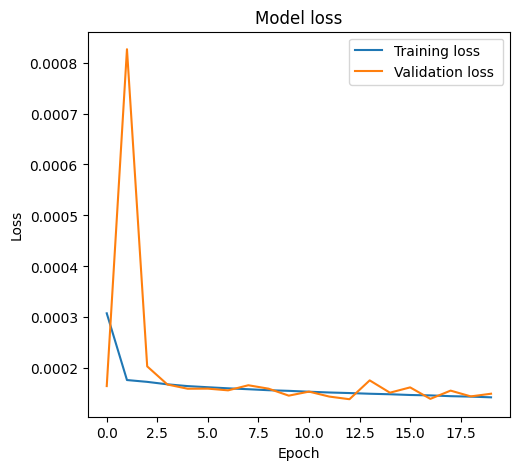

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss ')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [7]:
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression



TypeError: Ticker.__init__() missing 1 required positional argument: 'ticker'